In [1]:
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import utils as utils
import torchvision
from torch.cuda.amp import autocast, GradScaler
from imblearn.over_sampling import RandomOverSampler
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, WeightedRandomSampler
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import warnings
from torchvision import transforms
from PIL import Image

# Ignore a specific warning
warnings.filterwarnings("ignore")

2024-03-04 13:09:37.008072: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-04 13:09:37.851503: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/lukas/miniconda3/envs/practical_work/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/lukas/miniconda3/envs/practical_work/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed be

In [2]:
# set some seeds
seed = 1908
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

# Facial Expression Recognition Challenge

## Overview
This notebook takes part in the Facial Expression Recognition Challenge introduced in 2013. The challenge focuses on a facial expression classification dataset gathered from the internet. The challenge ended on Friday, May 31, 2013, with the best achieved accuracy on the public leaderboard of 0.69768 and of 0.71161 on the private leaderboard. The aim of this notebook is to achieve better results, using more advanced ML techniques.

## Challenge Details
### Dataset
The dataset for this challenge comprises facial expressions in 35887 48 x 48 greyscale images, where 28709 of these samples belong to the training set, 3589 to the public test set and 3589 to the private test set. All datasets are very unbalanced, making solutions to the inbalance problems one of the key challanges to achieve a high accuracy score.

### Evaluation
Submissions are scored based on the accuracy of predicting the appropriate emotion class for each image. During the contest, a public leaderboard was maintained and to prevent manual labeling of test data, the final test inputs were only be provided 72 hours before the contest closed to get the final score on the private test set.

## Citation
This challenge is part of the ICML 2013 Workshop on Challenges in Representation Learning. More details about the competition and its results can be found in the following publication:

**Title:** Challenges in Representation Learning: A report on three machine learning contests

**Authors:** Ian Goodfellow, Dumitru Erhan, Pierre-Luc Carrier, Aaron Courville, Mehdi Mirza, Ben Hamner, Will Cukierski, Yichuan Tang, David Thaler, Dong-Hyun Lee, Yingbo Zhou, Chetan Ramaiah, Fangxiang Feng, Ruifan Li, Xiaojie Wang, Dimitris Athanasakis, John Shawe-Taylor, Maxim Milakov, John Park, Radu Ionescu, Marius Popescu, Cristian Grozea, James Bergstra, Jingjing Xie, Lukasz Romaszko, Bing Xu, Zhang Chuang, Yoshua Bengio

**Year:** 2013

**URL:** [Challenges in Representation Learning: A report on three machine learning contests](http://arxiv.org/abs/1307.0414)

This publication provides insights into the challenges, datasets, and results of the ICML 2013 Workshop on Challenges in Representation Learning.

*For more information about the workshop and competition, visit [ICML 2013 Workshop Competition](http://deeplearning.net/icml2013-workshop-competition).*


# Code

## Set up data paths

In [3]:
working_dir = os.getcwd()
dataset_path = "fer2013/fer2013/fer2013.csv"
data_path = os.path.join(working_dir, dataset_path)

In [4]:
df = pd.read_csv(data_path)

## First look at the data and samples

In [5]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [6]:
print(f"Total number of samples: {len(df)}")

Total number of samples: 35887


In [7]:
sample_0 = df.iloc[0]

In [8]:
print(sample_0)
print(f"Number of pixels for one sample: {len(sample_0['pixels'].split(' '))}")

emotion                                                    0
pixels     70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
Usage                                               Training
Name: 0, dtype: object
Number of pixels for one sample: 2304


In [9]:
print(f"Shape of one image: {int(2304**(0.5))}")

Shape of one image: 48


In [10]:
print(f"Distinct emotion classes: {sorted(df['emotion'].unique())}")
print(f"Distinct Usage (Set) classes: {df['Usage'].unique()}")

Distinct emotion classes: [0, 1, 2, 3, 4, 5, 6]
Distinct Usage (Set) classes: ['Training' 'PublicTest' 'PrivateTest']


In [11]:
df.emotion

0        0
1        0
2        2
3        4
4        6
        ..
35882    6
35883    3
35884    0
35885    3
35886    2
Name: emotion, Length: 35887, dtype: int64

In [12]:
emotions_dict = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

## Plot the occurence of the different labels in the whole dataset

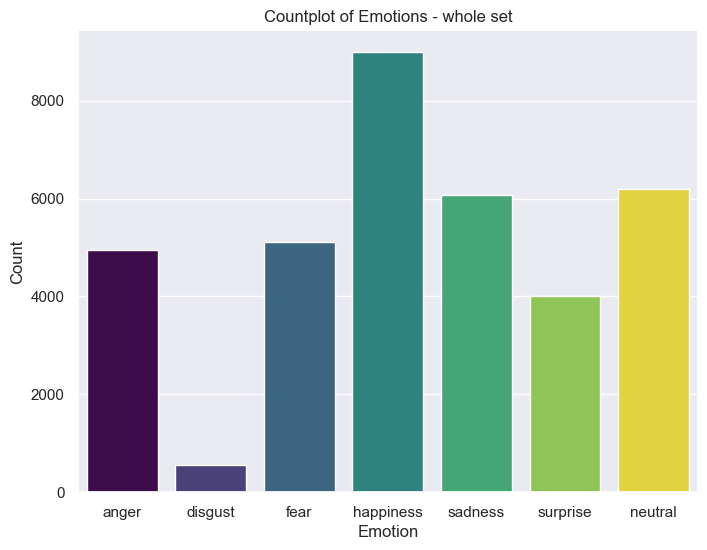

In [13]:
utils.plot_emotion_count(df, emotions_dict, "whole set")

## Plot the images with the corresponding labels

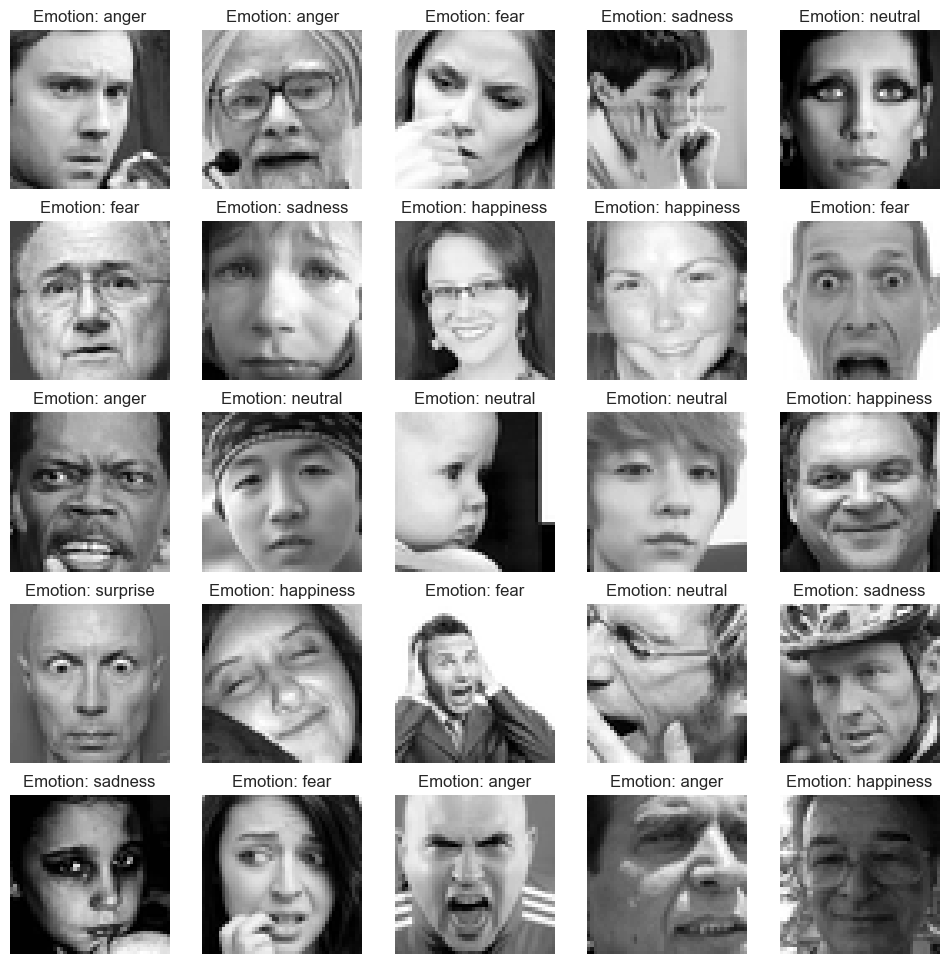

In [14]:
utils.show_images(df, emotions_dict, num_images=25, num_cols=5)

## Split the data into train, validation and test

In [15]:
# Split the dataset based on the "Usage" column
train_df = df[df['Usage'] == 'Training']
public_test_df = df[df['Usage'] == 'PublicTest']
private_test_df = df[df['Usage'] == 'PrivateTest']

In [16]:
# Print the lengths of the sets
print(f"Training set length: {len(train_df)}")
print(f"Public Test set set length: {len(public_test_df)}")
print(f"Private Test set length: {len(private_test_df)}")   

Training set length: 28709
Public Test set set length: 3589
Private Test set length: 3589


## Plot label occurence for all individual sets

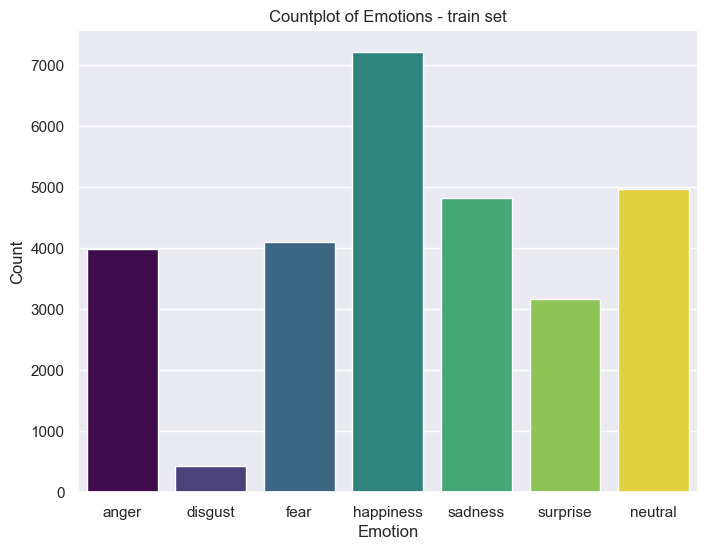

In [17]:
utils.plot_emotion_count(train_df, emotions_dict, "train set")

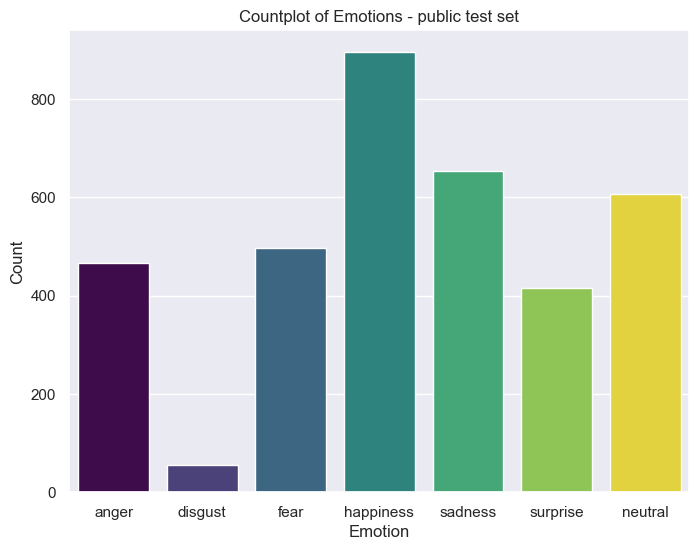

In [18]:
utils.plot_emotion_count(public_test_df, emotions_dict, "public test set")

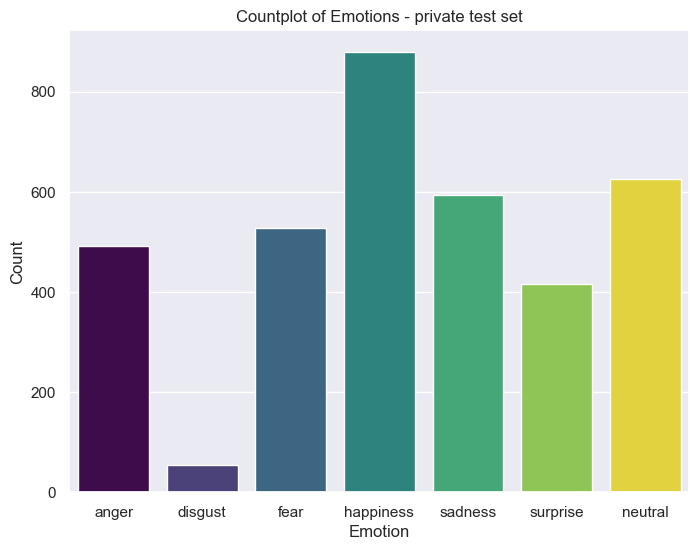

In [19]:
utils.plot_emotion_count(private_test_df, emotions_dict, "private test set")

## Split the sets into data and labels

In [20]:
train_labels, train_data = utils.split_labels_and_data(train_df)
public_test_labels, public_test_data = utils.split_labels_and_data(public_test_df)
private_test_labels, private_test_data = utils.split_labels_and_data(private_test_df)

In [21]:
# some more preprocessing of the data
train_data = utils.convert_string_to_int_array(train_data)
public_test_data = utils.convert_string_to_int_array(public_test_data)
private_test_data = utils.convert_string_to_int_array(private_test_data)

In [22]:
train_labels = train_labels.values
public_test_labels = public_test_labels.values
private_test_labels = private_test_labels.values

In [23]:
print(len(train_data))

28709


## Create a custom dataset class

In [24]:
from torch.utils.data import Dataset, DataLoader, random_split
import math

In [25]:
train_dataset = utils.CustomDataset(train_data, train_labels)
public_test_set = utils.CustomDataset(public_test_data, public_test_labels)
private_test_set = utils.CustomDataset(private_test_data, private_test_labels)

# split further into train and validation set
validation_set_fraction = 0.15
train_set_length = math.floor(len(train_dataset) * (1-validation_set_fraction))
validation_set_length = math.ceil(len(train_dataset) * (validation_set_fraction))

# train validation split
train_set, val_set = torch.utils.data.random_split(train_dataset, [train_set_length, validation_set_length])

# Simple CNN for first tests

In [60]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(9216, 512)  
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 12 * 12)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [61]:
m = SimpleCNN()

In [62]:
test = torch.rand(size=(1,1,48,48))

In [63]:
print(train_dataset.__getitem__(0)[0].shape)

torch.Size([1, 48, 48])


In [64]:
m(test)

torch.Size([1, 32, 48, 48])
torch.Size([1, 32, 24, 24])
torch.Size([1, 64, 24, 24])
torch.Size([1, 64, 12, 12])
torch.Size([1, 9216])


tensor([[-0.0343,  0.0432,  0.0114, -0.0257, -0.0126, -0.0994,  0.0488]],
       grad_fn=<AddmmBackward0>)

In [27]:
# set up cude if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Set up Dataloaders

In [28]:
# get the fraction of the trainset used in every epoch
train_set_sample_fraction = 1

# Calculate the size of the random train subset based on the fraction
train_subset_size = int(len(train_set) * train_set_sample_fraction)
# number of samples
n_samples = int(len(train_set)*train_set_sample_fraction)

# Use a RandomSampler with random indices
random_sampler = RandomSampler(data_source=train_set, num_samples=n_samples, replacement=True)

# DataLoader setup
batch_size = 512

train_dataloader = DataLoader(train_set, batch_size, sampler=random_sampler)
valid_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
public_test_dataloader = DataLoader(public_test_set, batch_size=batch_size, shuffle=False)
private_test_dataloader = DataLoader(private_test_set, batch_size=batch_size, shuffle=False)

In [29]:
# load tensorboard
%load_ext tensorboard
%tensorboard --logdir=runs

## Training

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, RandomSampler
from torch.utils.tensorboard import SummaryWriter

# set up some hyperparams and saving paths
learning_rate = 0.001
save_path = 'models/best_simple_model.pth'
epochs = 250
writer = SummaryWriter(log_dir="runs/experiment_simple_CNN", comment='SimpleCNN')

# Initialize model, loss function, optimizer
model = SimpleCNN()
model.to(device)

# Add the model structure to tensorboard
example_input = torch.randn(1, 1, 48, 48).to(device)
writer.add_graph(model, example_input)
writer.close()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scaler = GradScaler()

# early stopping
patience = 15
# Start the training loop

#utils.train(train_dataloader, valid_dataloader, model, criterion, optimizer, epochs, save_path, writer, device, scaler, patience)

## Test model (classification report, confusion matrix and misclassified images)

In [31]:
# Create an instance of the model
model = SimpleCNN()

# Load the saved model state dictionary
model.load_state_dict(torch.load('models/best_simple_model.pth'))

<All keys matched successfully>

In [32]:
model

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=7, bias=True)
)

## Test on Public Test set

Testing:   0%|          | 0/8 [00:00<?, ?it/s]


Classification Report:

              precision    recall  f1-score   support

       anger     0.4688    0.2248    0.3039       467
     disgust     0.6250    0.0893    0.1562        56
        fear     0.3467    0.2782    0.3087       496
   happiness     0.6434    0.7620    0.6977       895
     sadness     0.3785    0.4701    0.4194       653
    surprise     0.5879    0.7012    0.6396       415
     neutral     0.4604    0.4498    0.4550       607

    accuracy                         0.5018      3589
   macro avg     0.5015    0.4251    0.4258      3589
weighted avg     0.4938    0.5018    0.4858      3589





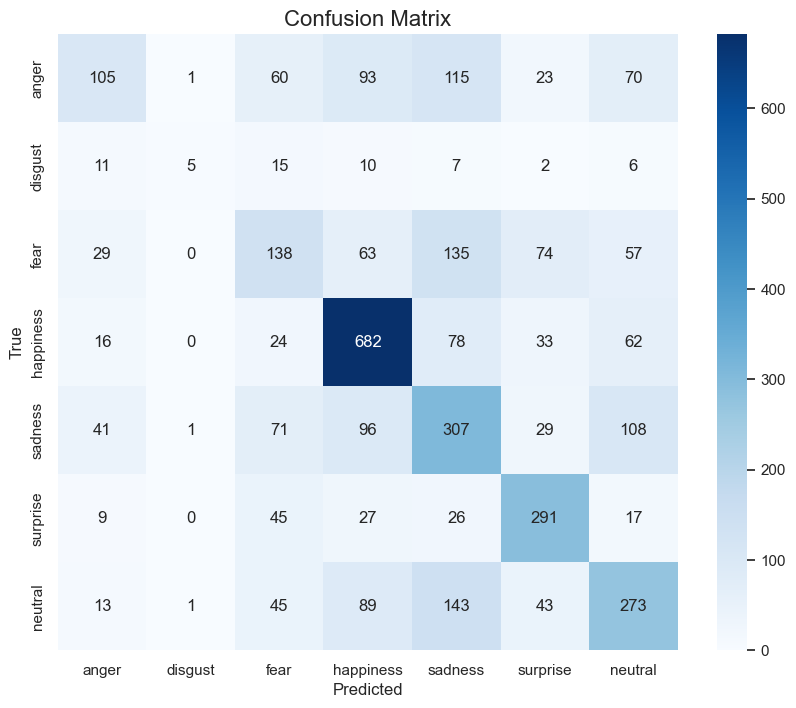



Misclassified Images: 



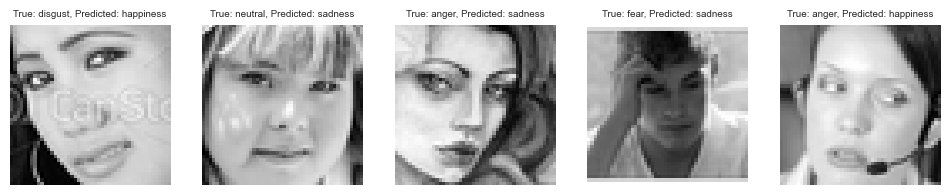

In [33]:
utils.test(model, public_test_dataloader, emotions_dict, device, plot_misclassified=True, num_misclassified=5)

## Test on Private Test set

Testing:   0%|          | 0/8 [00:00<?, ?it/s]


Classification Report:

              precision    recall  f1-score   support

       anger     0.4807    0.2281    0.3094       491
     disgust     0.5000    0.0909    0.1538        55
        fear     0.3349    0.2727    0.3006       528
   happiness     0.6263    0.7816    0.6953       879
     sadness     0.3475    0.4411    0.3887       594
    surprise     0.5811    0.6803    0.6268       416
     neutral     0.5087    0.4696    0.4884       626

    accuracy                         0.4979      3589
   macro avg     0.4827    0.4235    0.4233      3589
weighted avg     0.4897    0.4979    0.4814      3589





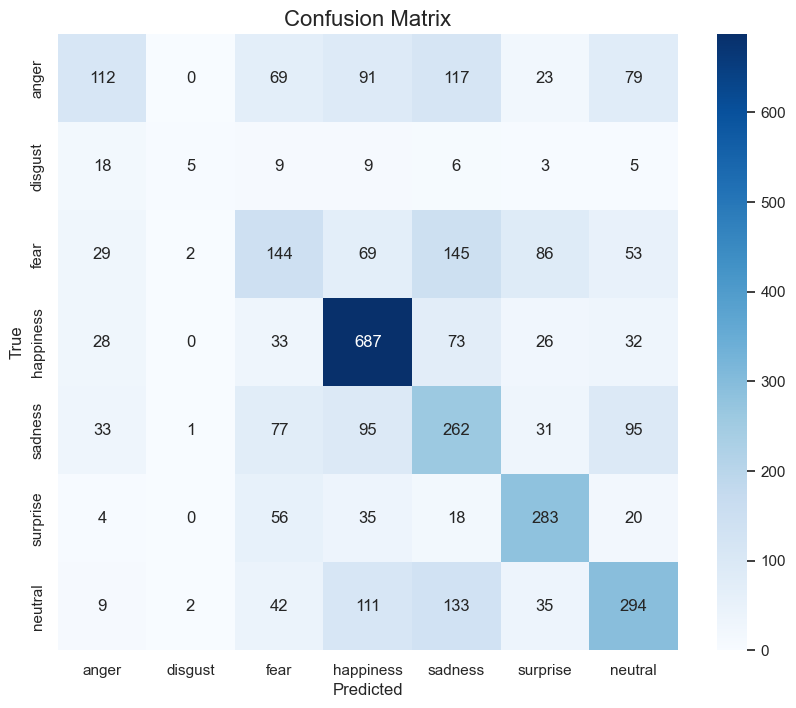



Misclassified Images: 



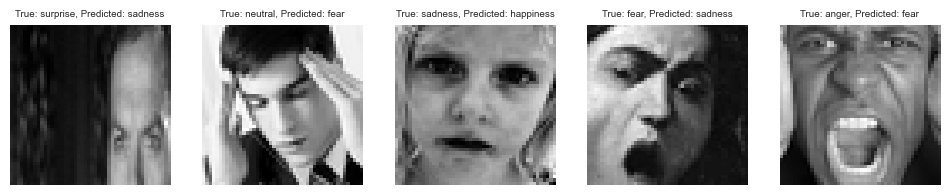

In [34]:
utils.test(model, private_test_dataloader, emotions_dict, device, plot_misclassified=True, num_misclassified=5)

## Resample the training data

In [35]:
# get the fraction of the trainset used in every epoch
train_set_sample_fraction = 1

# get the train_sample_weights
train_sample_weights = utils.get_datapoint_weights(train_set)

# Calculate the size of the random train subset based on the fraction
train_subset_size = int(len(train_set) * train_set_sample_fraction)
# number of samples
n_samples = int(len(train_set)*train_set_sample_fraction)

# Use a WeightedRandomSampler with random indices
weighted_random_sampler = WeightedRandomSampler(weights=train_sample_weights, num_samples=n_samples, replacement=True)

# DataLoader setup
batch_size = 512

upsampled_train_dataloader = DataLoader(train_set, batch_size, sampler=weighted_random_sampler)

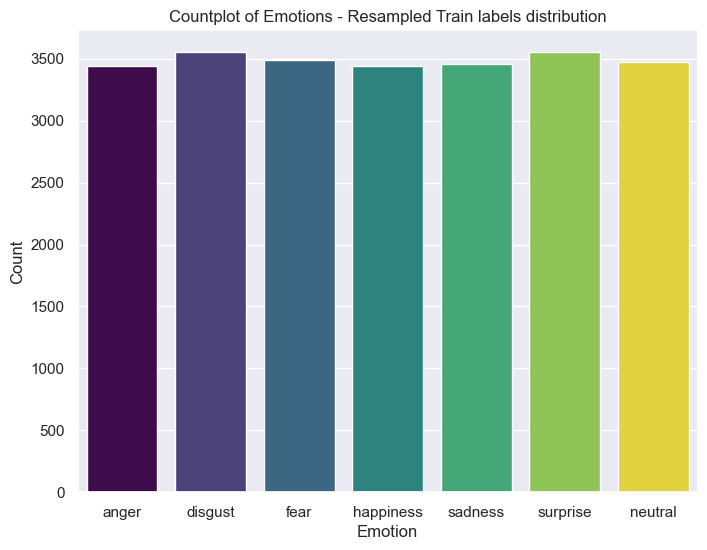

In [36]:
utils.plot_emotion_count(upsampled_train_dataloader, emotions_dict, "Resampled Train labels distribution")

## Training

In [41]:
# set up some hyperparams and saving paths
learning_rate = 0.001
save_path = 'models/best_simple_model_resampled.pth'
epochs = 250
writer = SummaryWriter(log_dir="runs/experiment_simple_CNN_resampled", comment='SimpleCNN_resampled')

# Initialize model, loss function, optimizer
model = SimpleCNN()
model.to(device)

# Add the model structure to tensorboard
example_input = torch.randn(1, 1, 48, 48).to(device)
writer.add_graph(model, example_input)
writer.close()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scaler = GradScaler()

# early stopping
patience = 15
# Start the training loop

#utils.train(upsampled_train_dataloader, valid_dataloader, model, criterion, optimizer, epochs, save_path, writer, device, scaler, patience)

## Test model (classification report, confusion matrix and misclassified images)

In [42]:
# Create an instance of the model
model = SimpleCNN()

# Load the saved model state dictionary
model.load_state_dict(torch.load('models/best_simple_model_resampled.pth'))

<All keys matched successfully>

## Test on Public Testset

Testing:   0%|          | 0/8 [00:00<?, ?it/s]


Classification Report:

              precision    recall  f1-score   support

       anger     0.4297    0.3405    0.3799       467
     disgust     0.5472    0.5179    0.5321        56
        fear     0.4000    0.2742    0.3254       496
   happiness     0.7310    0.6648    0.6963       895
     sadness     0.3781    0.4870    0.4257       653
    surprise     0.6813    0.6747    0.6780       415
     neutral     0.4329    0.5420    0.4813       607

    accuracy                         0.5143      3589
   macro avg     0.5143    0.5001    0.5027      3589
weighted avg     0.5228    0.5143    0.5136      3589





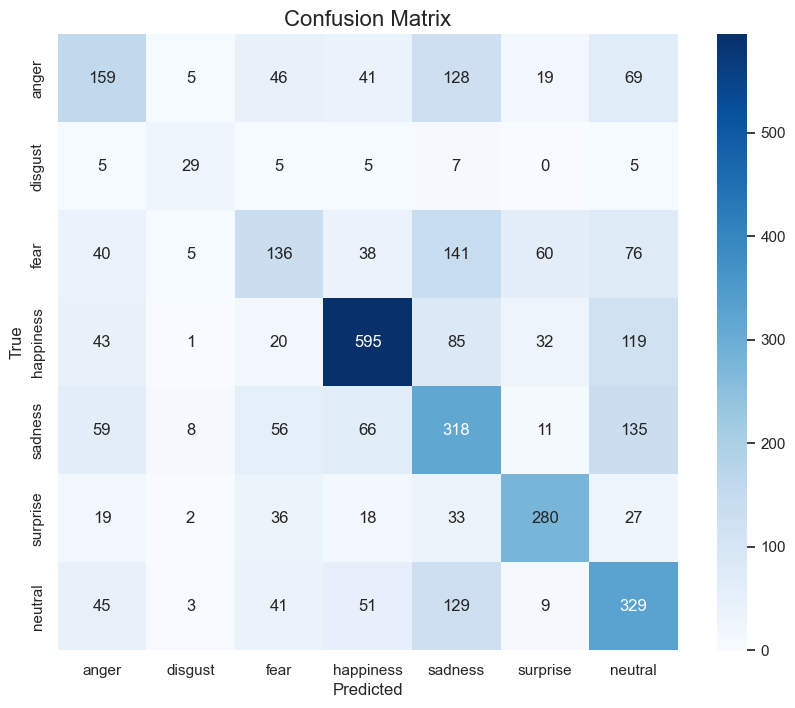



Misclassified Images: 



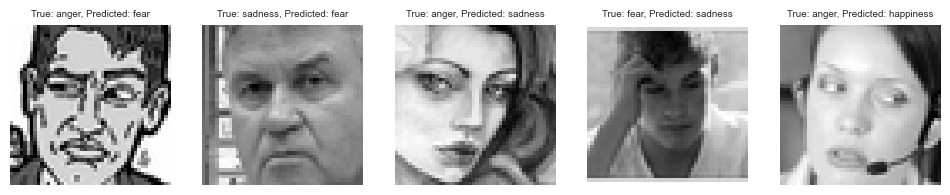

In [43]:
utils.test(model, public_test_dataloader, emotions_dict, device, plot_misclassified=True, num_misclassified=5)

## Test on Private Test set

Testing:   0%|          | 0/8 [00:00<?, ?it/s]


Classification Report:

              precision    recall  f1-score   support

       anger     0.4271    0.3340    0.3749       491
     disgust     0.5085    0.5455    0.5263        55
        fear     0.3975    0.3011    0.3427       528
   happiness     0.7361    0.6758    0.7046       879
     sadness     0.3577    0.4865    0.4123       594
    surprise     0.6941    0.6490    0.6708       416
     neutral     0.4744    0.5623    0.5146       626

    accuracy                         0.5177      3589
   macro avg     0.5136    0.5077    0.5066      3589
weighted avg     0.5274    0.5177    0.5181      3589





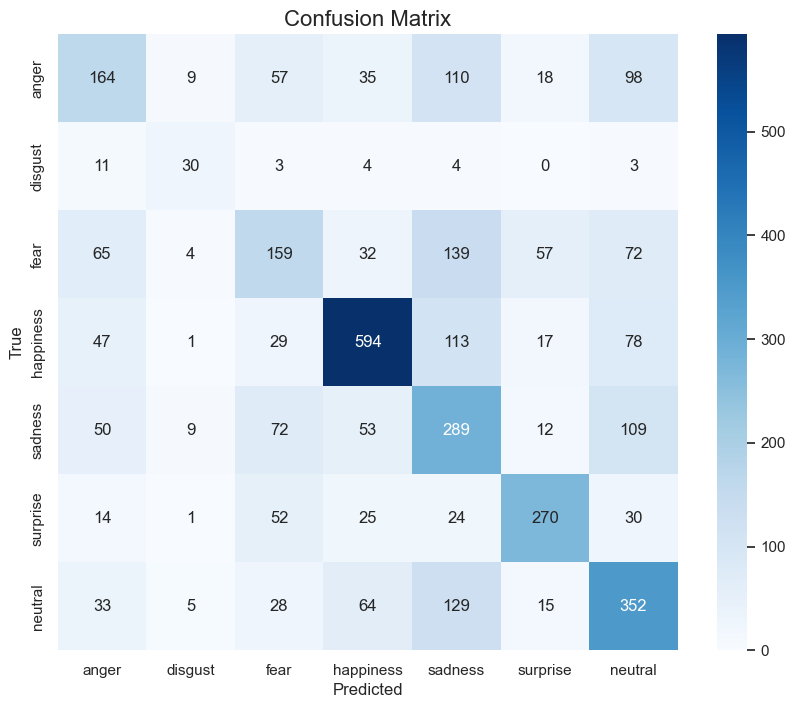



Misclassified Images: 



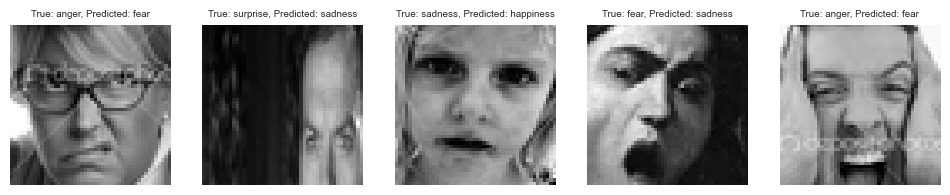

In [44]:
utils.test(model, private_test_dataloader, emotions_dict, device, plot_misclassified=True, num_misclassified=5)

Resampling did not lead to better accuracy!

## Data augmentation

In [45]:
from torchvision import transforms
from PIL import Image
from torch.utils.data import Subset

# Define the transformations 
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.RandomResizedCrop(size=(48, 48), scale=(0.8, 1.2), ratio=(0.9, 1.1)),
    transforms.RandomAffine(degrees=10, scale=(0.9, 1.1), shear=5),
    transforms.ToTensor()
])

# Create augmented subsets with transformations
train_set_augmented = utils.CustomDataset(train_data, train_labels, train_transform)

In [46]:
# get the fraction of the trainset used in every epoch
train_set_sample_fraction = 1

# Calculate the size of the random train subset based on the fraction
train_subset_size = int(len(train_set_augmented) * train_set_sample_fraction)

# number of samples
n_samples = int(len(train_set_augmented)*train_set_sample_fraction)

# Use a RandomSampler with random indices
random_sampler = RandomSampler(data_source=train_set_augmented, num_samples=n_samples, replacement=True)

# DataLoader setup
batch_size = 512

train_dataloader_augmented = DataLoader(train_set_augmented, batch_size, sampler=random_sampler)

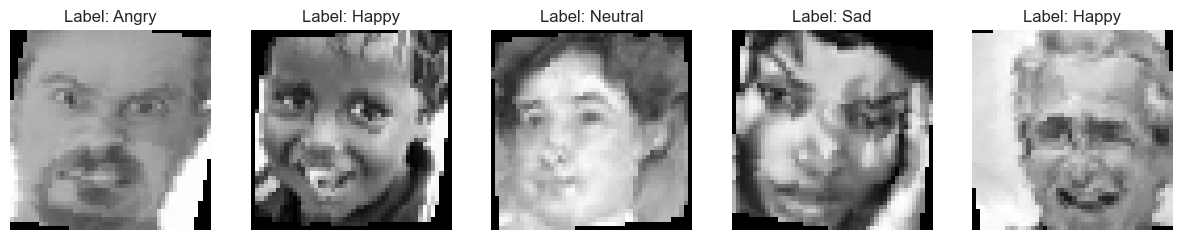

In [47]:
def plot_batch_images(images, labels, k=5):
    """
    Plot the first "k" original and augmented images from a batch.

    Parameters:
    - images (torch.Tensor): The batch of images.
    - labels (torch.Tensor): The corresponding labels.
    - k (int): Number of pairs of images to plot.

    Returns:
    None
    """

    label_dict = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
    
    fig, axes = plt.subplots(1, k, figsize=(15, 6))

    for i in range(k):
        # Get the i-th original image from the batch
        image = images[i].squeeze().numpy()

        # Plot original image
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f"Label: {label_dict[labels[i].item()]}")
        axes[i].axis('off')
    plt.show()

# Example usage
for batch in train_dataloader_augmented:
    images, labels = batch
    plot_batch_images(images, labels, k=5)
    break

In [48]:
# set up some hyperparams and saving paths
learning_rate = 0.001
save_path = 'models/best_simple_model_augmented.pth'
epochs = 250
writer = SummaryWriter(log_dir="runs/experiment_simple_CNN_augmented", comment='SimpleCNN_augmented')

# Initialize model, loss function, optimizer
model = SimpleCNN()
model.to(device)

# Add the model structure to tensorboard
example_input = torch.randn(1, 1, 48, 48).to(device)
writer.add_graph(model, example_input)
writer.close()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scaler = GradScaler()

# early stopping
patience = 15

# Start the training loop
#utils.train(train_dataloader_augmented, valid_dataloader, model, criterion, optimizer, epochs, save_path, writer, device, scaler, patience)

In [49]:
## Test model (classification report, confusion matrix and misclassified images)

In [50]:
# Create an instance of the model
model = SimpleCNN()

# Load the saved model state dictionary
model.load_state_dict(torch.load('models/best_simple_model_augmented.pth'))

<All keys matched successfully>

In [54]:
# Public Test set

Testing:   0%|          | 0/8 [00:00<?, ?it/s]


Classification Report:

              precision    recall  f1-score   support

       anger     0.5069    0.4732    0.4895       467
     disgust     0.8824    0.5357    0.6667        56
        fear     0.4479    0.4073    0.4266       496
   happiness     0.7918    0.7777    0.7847       895
     sadness     0.4849    0.4441    0.4636       653
    surprise     0.6943    0.7880    0.7381       415
     neutral     0.4972    0.5898    0.5396       607

    accuracy                         0.5918      3589
   macro avg     0.6151    0.5737    0.5870      3589
weighted avg     0.5917    0.5918    0.5897      3589





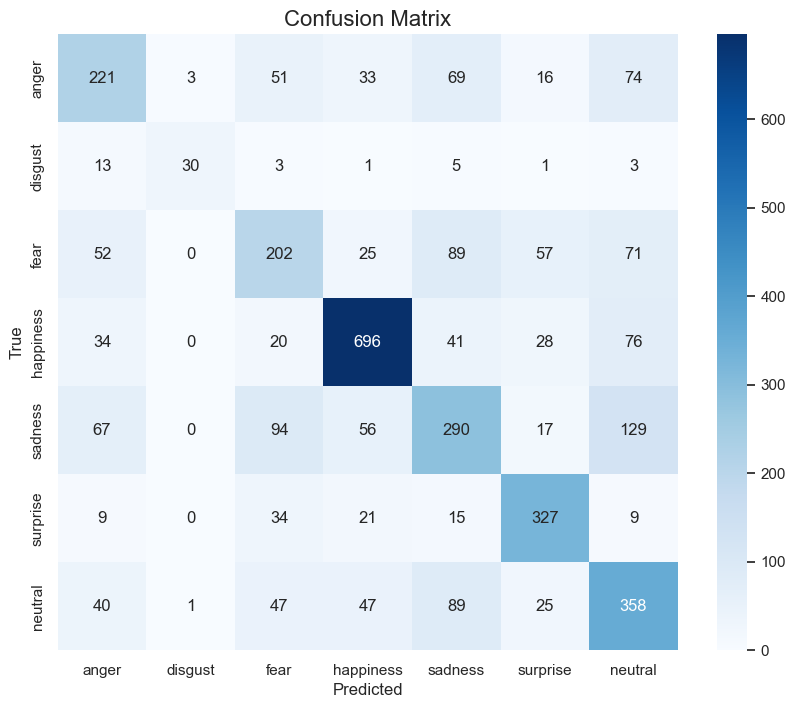



Misclassified Images: 



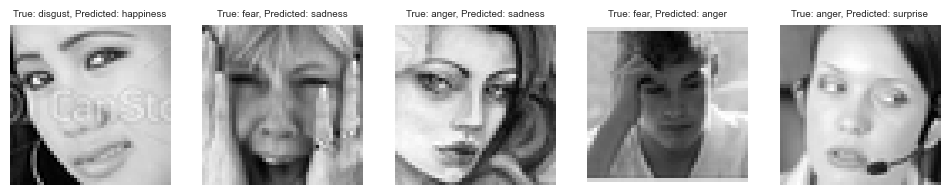

In [55]:
utils.test(model, public_test_dataloader, emotions_dict, device, plot_misclassified=True, num_misclassified=5)

In [56]:
## Private Test set

Testing:   0%|          | 0/8 [00:00<?, ?it/s]


Classification Report:

              precision    recall  f1-score   support

       anger     0.5172    0.4582    0.4860       491
     disgust     0.7857    0.6000    0.6804        55
        fear     0.4672    0.4186    0.4416       528
   happiness     0.8118    0.7850    0.7981       879
     sadness     0.4671    0.4545    0.4608       594
    surprise     0.7351    0.8005    0.7664       416
     neutral     0.5317    0.6438    0.5824       626

    accuracy                         0.6060      3589
   macro avg     0.6165    0.5944    0.6022      3589
weighted avg     0.6056    0.6060    0.6040      3589





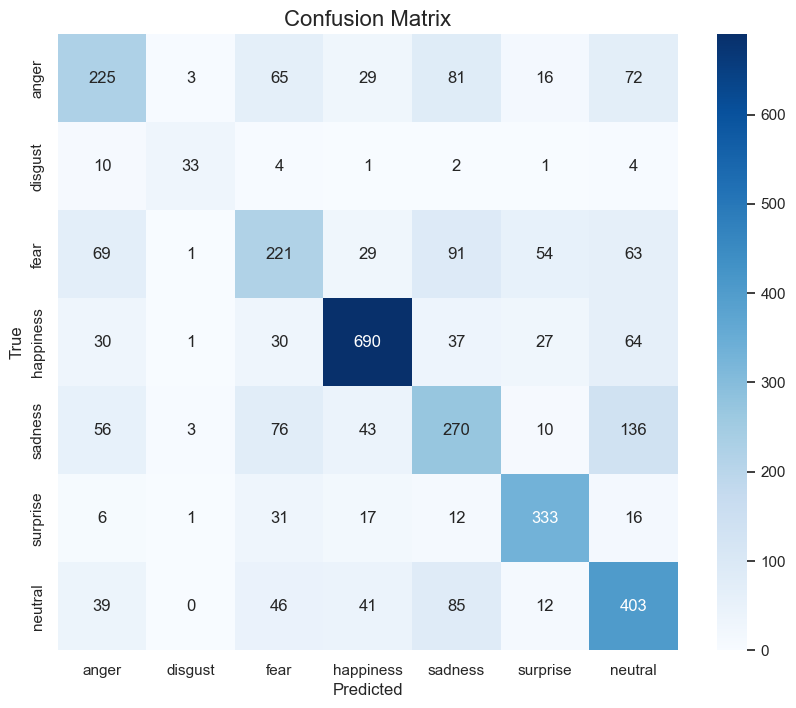



Misclassified Images: 



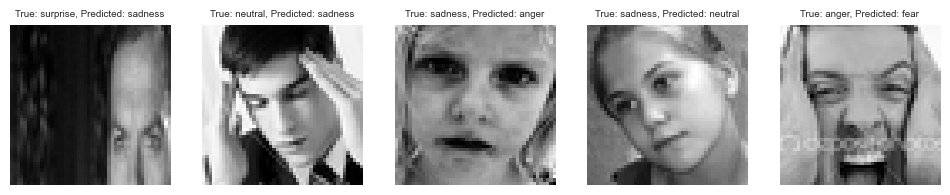

In [57]:
utils.test(model, private_test_dataloader, emotions_dict, device, plot_misclassified=True, num_misclassified=5)

# Augmentation with upsampling

In [58]:
# get the fraction of the trainset used in every epoch
train_set_sample_fraction = 1

# get the train_sample_weights
train_sample_weights = utils.get_datapoint_weights(train_set)

# Calculate the size of the random train subset based on the fraction
train_subset_size = int(len(train_set) * train_set_sample_fraction)
# number of samples
n_samples = int(len(train_set)*train_set_sample_fraction)

# Use a WeightedRandomSampler with random indices
weighted_random_sampler = WeightedRandomSampler(weights=train_sample_weights, num_samples=n_samples, replacement=True)

# DataLoader setup
batch_size = 512

upsampled_train_dataloader_augmented = DataLoader(train_set_augmented, batch_size, sampler=weighted_random_sampler)

In [63]:
# set up some hyperparams and saving paths
learning_rate = 0.001
save_path = 'models/best_simple_model_augmented_upsampled.pth'
epochs = 250
writer = SummaryWriter(log_dir="runs/experiment_simple_CNN_augmented_upsampled", comment='SimpleCNN_augmented_upsampled')

# Initialize model, loss function, optimizer
model = SimpleCNN()
model.to(device)

# Add the model structure to tensorboard
example_input = torch.randn(1, 1, 48, 48).to(device)
writer.add_graph(model, example_input)
writer.close()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scaler = GradScaler()

# early stopping
patience = 15

# Start the training loop
#utils.train(upsampled_train_dataloader_augmented, valid_dataloader, model, criterion, optimizer, epochs, save_path, writer, device, scaler, patience)

In [64]:
# Create an instance of the model
model = SimpleCNN()

# Load the saved model state dictionary
model.load_state_dict(torch.load('models/best_simple_model_augmented_upsampled.pth'))

<All keys matched successfully>

Testing:   0%|          | 0/8 [00:00<?, ?it/s]


Classification Report:

              precision    recall  f1-score   support

       anger     0.4828    0.4818    0.4823       467
     disgust     0.7353    0.4464    0.5556        56
        fear     0.4692    0.4294    0.4484       496
   happiness     0.7704    0.8022    0.7860       895
     sadness     0.4744    0.4686    0.4715       653
    surprise     0.7376    0.7518    0.7446       415
     neutral     0.5134    0.5371    0.5250       607

    accuracy                         0.5921      3589
   macro avg     0.5976    0.5596    0.5733      3589
weighted avg     0.5897    0.5921    0.5901      3589





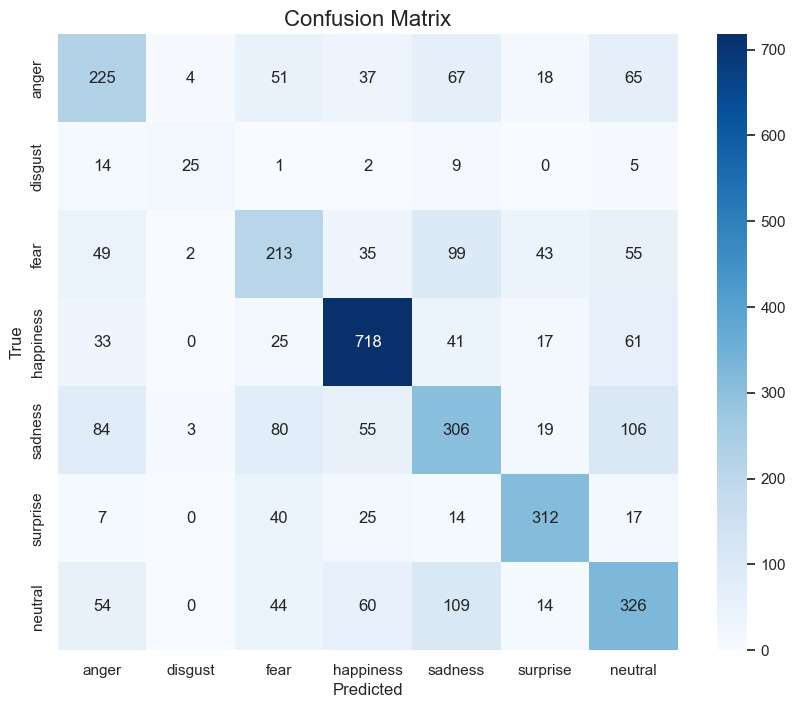



Misclassified Images: 



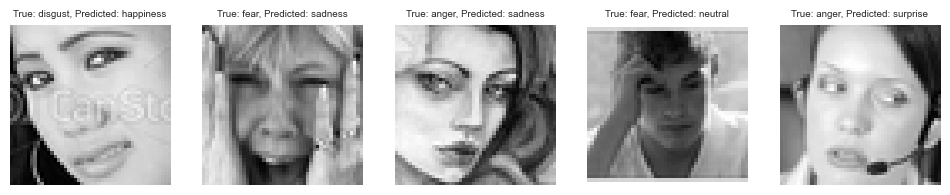

In [65]:
utils.test(model, public_test_dataloader, emotions_dict, device, plot_misclassified=True, num_misclassified=5)

Testing:   0%|          | 0/8 [00:00<?, ?it/s]


Classification Report:

              precision    recall  f1-score   support

       anger     0.4807    0.4827    0.4817       491
     disgust     0.6250    0.4545    0.5263        55
        fear     0.4743    0.4375    0.4552       528
   happiness     0.7739    0.8020    0.7877       879
     sadness     0.4436    0.4697    0.4563       594
    surprise     0.7403    0.6851    0.7116       416
     neutral     0.5668    0.5831    0.5748       626

    accuracy                         0.5926      3589
   macro avg     0.5864    0.5592    0.5705      3589
weighted avg     0.5927    0.5926    0.5921      3589





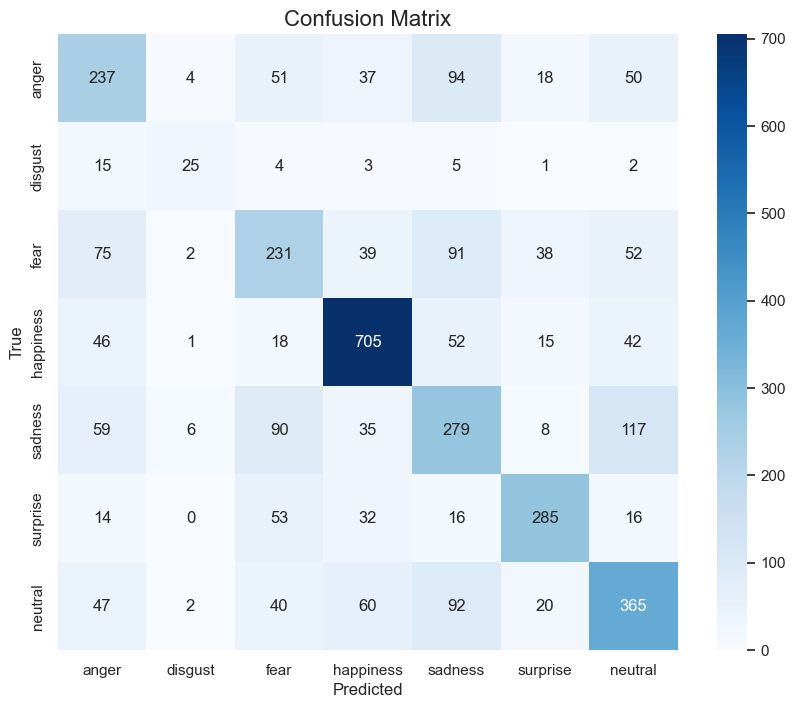



Misclassified Images: 



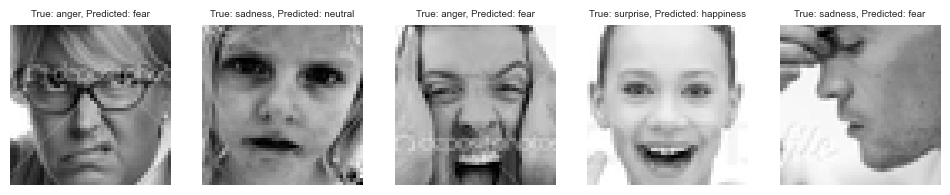

In [66]:
utils.test(model, private_test_dataloader, emotions_dict, device, plot_misclassified=True, num_misclassified=5)

In [67]:
# load tensorboard
%load_ext tensorboard
%tensorboard --logdir=runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 29851), started 0:02:25 ago. (Use '!kill 29851' to kill it.)

# Use Advanced Model (ConvNeXt Tiny)
https://pytorch.org/vision/main/models/generated/torchvision.models.convnext_tiny.html#torchvision.models.convnext_tiny

In [68]:
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights

def create_custom_convext_net(freeze_pretrained=False):
    # Load pretrained ConvNeXt model
    convnext_tiny = torchvision.models.convnext_tiny(weights=ConvNeXt_Tiny_Weights.DEFAULT)

    # Freeze all pretrained layers
    if freeze_pretrained:
        for param in convnext_tiny.parameters():
            param.requires_grad = False

    # Modify the final fully connected layer for the specified number of classes
    in_features = 768  # Number of features of the classifier
    out_features = 7  # Number of output classes
    convnext_tiny.classifier[-1] = nn.Linear(in_features, out_features, bias=True)

    # Create a list of parameters to be optimized
    parameters_to_optimize = filter(lambda p: p.requires_grad, convnext_tiny.parameters())

    return convnext_tiny, parameters_to_optimize

In [69]:
convnext_tiny_baseline, _ = create_custom_convext_net()

In [70]:
# Print the modified model architecture
print(convnext_tiny_baseline)

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [71]:
# Define the transformations for ConvNeXt model
resize_size = [230]
crop_size = [224]
normalize_mean = [0.485, 0.456, 0.406]
normalize_std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize(resize_size, interpolation=Image.BILINEAR),
    transforms.CenterCrop(crop_size),
    transforms.Grayscale(num_output_channels=3),  # Convert to 3 channels
    transforms.ToTensor(),
    transforms.Normalize(mean=normalize_mean, std=normalize_std)
])

train_dataset = utils.CustomDataset(train_data, train_labels, transform=transform)
public_test_set = utils.CustomDataset(public_test_data, public_test_labels, transform=transform)
private_test_set = utils.CustomDataset(private_test_data, private_test_labels, transform=transform)

# split further into train and validation set
validation_set_fraction = 0.15
train_set_length = math.floor(len(train_dataset) * (1-validation_set_fraction))
validation_set_length = math.ceil(len(train_dataset) * (validation_set_fraction))

# train validation split
train_set, val_set = torch.utils.data.random_split(train_dataset, [train_set_length, validation_set_length])

## Set Up Dataloaders again for baseline training

In [72]:
# get the fraction of the trainset used in every epoch
train_set_sample_fraction = 0.025

# Calculate the size of the random train subset based on the fraction
train_subset_size = int(len(train_set) * train_set_sample_fraction)
# number of samples
n_samples = int(len(train_set)*train_set_sample_fraction)

# Use a RandomSampler
random_sampler = RandomSampler(data_source=train_set, num_samples=n_samples, replacement=True)

# DataLoader setup
batch_size = 16

train_dataloader = DataLoader(train_set, batch_size, sampler=random_sampler)
valid_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
public_test_dataloader = DataLoader(public_test_set, batch_size=batch_size, shuffle=False)
private_test_dataloader = DataLoader(private_test_set, batch_size=batch_size, shuffle=False)

In [74]:
# load tensorboard
%load_ext tensorboard
%tensorboard --logdir=runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 29851), started 0:02:50 ago. (Use '!kill 29851' to kill it.)

In [78]:
# set up some hyperparams and saving paths
learning_rate = 0.0001
save_path = 'models/CovNext_baseline.pth'
epochs = 250
writer = SummaryWriter(log_dir="runs/experiment_CovNext_baseline", comment='CovNext_baseline')

# Initialize model, loss function, optimizer
convnext_tiny_baseline.to(device)

# Add the model structure to tensorboard
example_input = torch.randn(1, 3, 224, 224).to(device)
writer.add_graph(convnext_tiny_baseline, example_input)
writer.close()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(convnext_tiny_baseline.parameters(), lr=learning_rate)
scaler = GradScaler()

# early stopping
patience = 15

# Start the training loop
#utils.train(train_dataloader, valid_dataloader, convnext_tiny_baseline, criterion, optimizer, epochs, save_path, writer, device, scaler, patience)

## Test model (classification report, confusion matrix and misclassified images)

In [79]:
# Create an instance of the model

# Load the saved model state dictionary
convnext_tiny_baseline.load_state_dict(torch.load('models/CovNext_baseline.pth'))#

<All keys matched successfully>

## Test on Public Test Set

Testing:   0%|          | 0/225 [00:00<?, ?it/s]


Classification Report:

              precision    recall  f1-score   support

       anger     0.5851    0.5889    0.5870       467
     disgust     0.8000    0.2857    0.4211        56
        fear     0.5156    0.3992    0.4500       496
   happiness     0.8618    0.8637    0.8627       895
     sadness     0.5085    0.6401    0.5668       653
    surprise     0.7710    0.7952    0.7829       415
     neutral     0.6320    0.5914    0.6111       607

    accuracy                         0.6601      3589
   macro avg     0.6677    0.5949    0.6116      3589
weighted avg     0.6633    0.6601    0.6573      3589





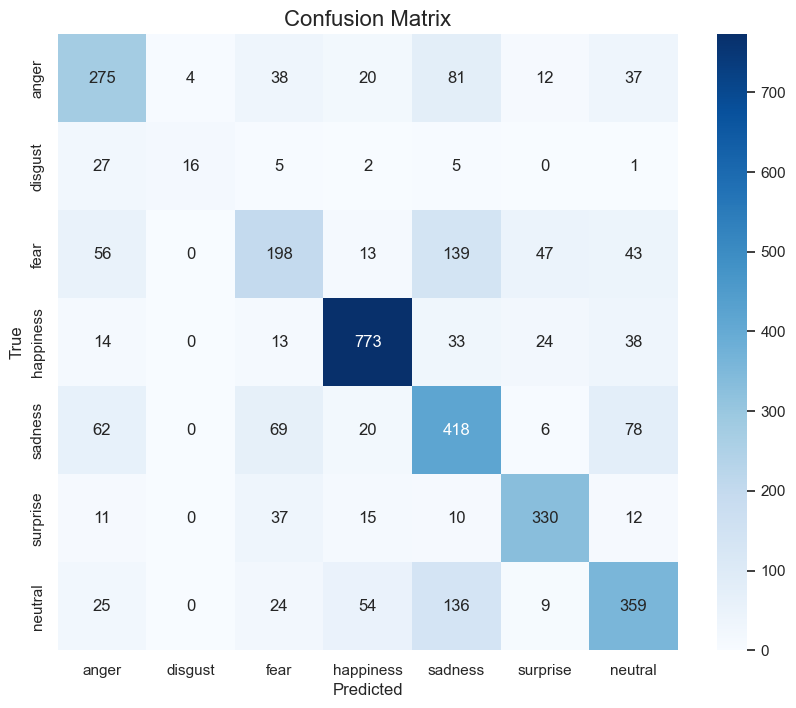



Misclassified Images: 



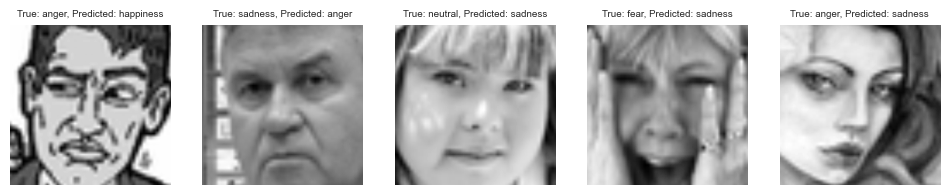

In [80]:
utils.test(convnext_tiny_baseline, public_test_dataloader, emotions_dict, device, plot_misclassified=True, num_misclassified=5)

## Test on Private Test Set

Testing:   0%|          | 0/225 [00:00<?, ?it/s]


Classification Report:

              precision    recall  f1-score   support

       anger     0.5844    0.5642    0.5741       491
     disgust     0.6923    0.1636    0.2647        55
        fear     0.5115    0.4205    0.4615       528
   happiness     0.8803    0.8953    0.8878       879
     sadness     0.4833    0.6330    0.5481       594
    surprise     0.7906    0.7260    0.7569       416
     neutral     0.6270    0.6150    0.6210       626

    accuracy                         0.6570      3589
   macro avg     0.6528    0.5739    0.5877      3589
weighted avg     0.6624    0.6570    0.6547      3589





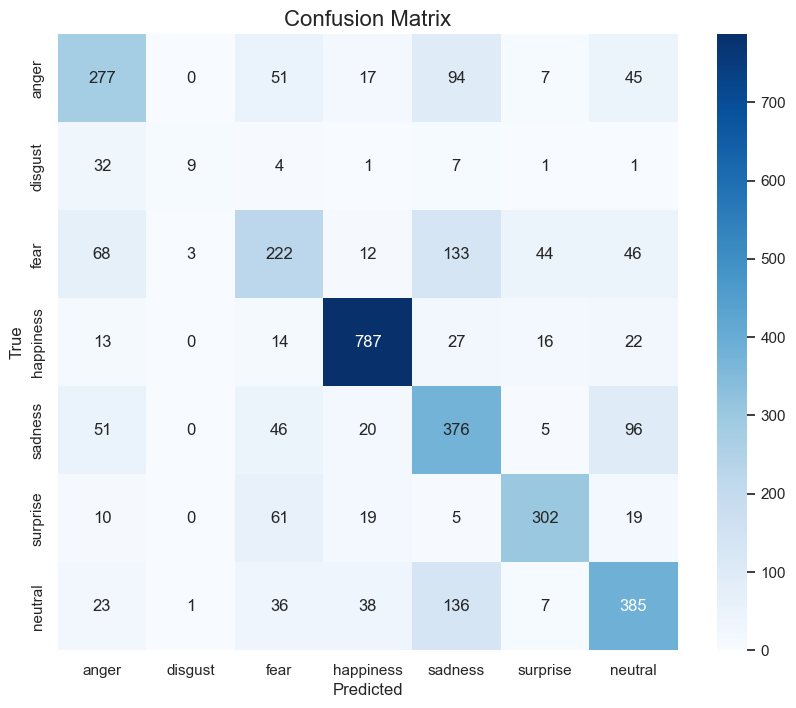



Misclassified Images: 



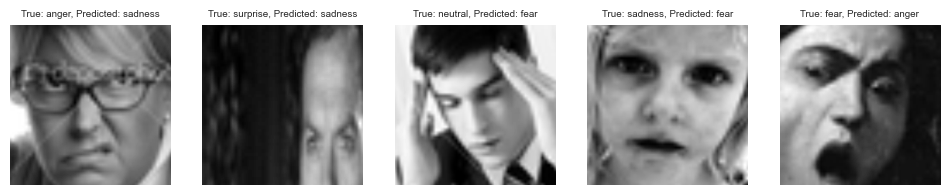

In [81]:
utils.test(convnext_tiny_baseline, private_test_dataloader, emotions_dict, device, plot_misclassified=True, num_misclassified=5)

# freeze pretrained layers and finetune later

In [82]:
convnext_tiny_pretrained, parameters_to_optimize = create_custom_convext_net(freeze_pretrained=True)

In [83]:
# get the fraction of the trainset used in every epoch
train_set_sample_fraction = 0.05

# Calculate the size of the random train subset based on the fraction
train_subset_size = int(len(train_set) * train_set_sample_fraction)
# number of samples
n_samples = int(len(train_set)*train_set_sample_fraction)

# Use a RandomSampler
random_sampler = RandomSampler(data_source=train_set, num_samples=n_samples, replacement=True)

# DataLoader setup
batch_size = 16

train_dataloader = DataLoader(train_set, batch_size, sampler=random_sampler)

In [84]:
# set up some hyperparams and saving paths
learning_rate = 0.0001
save_path = 'models/CovNext_frozen.pth'
epochs = 250
writer = SummaryWriter(log_dir="runs/experiment_CovNext_frozen", comment='CovNext_frozen')

# Initialize model, loss function, optimizer
convnext_tiny_pretrained.to(device)

# Add the model structure to tensorboard
example_input = torch.randn(1, 3, 224, 224).to(device)
writer.add_graph(convnext_tiny_pretrained, example_input)
writer.close()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(parameters_to_optimize, lr=learning_rate)
scaler = GradScaler()

# early stopping
patience = 15

# Start the training loop
#utils.train(train_dataloader, valid_dataloader, convnext_tiny_pretrained, criterion, optimizer, epochs, save_path, writer, device, scaler, patience)

In [85]:
convnext_tiny_pretrained.load_state_dict(torch.load('models/CovNext_frozen.pth'))

<All keys matched successfully>

Testing:   0%|          | 0/225 [00:00<?, ?it/s]


Classification Report:

              precision    recall  f1-score   support

       anger     0.4145    0.3426    0.3751       467
     disgust     0.5000    0.0714    0.1250        56
        fear     0.4232    0.2722    0.3313       496
   happiness     0.6357    0.8034    0.7098       895
     sadness     0.4263    0.4472    0.4365       653
    surprise     0.6452    0.7012    0.6721       415
     neutral     0.4696    0.4712    0.4704       607

    accuracy                         0.5258      3589
   macro avg     0.5021    0.4442    0.4457      3589
weighted avg     0.5103    0.5258    0.5102      3589





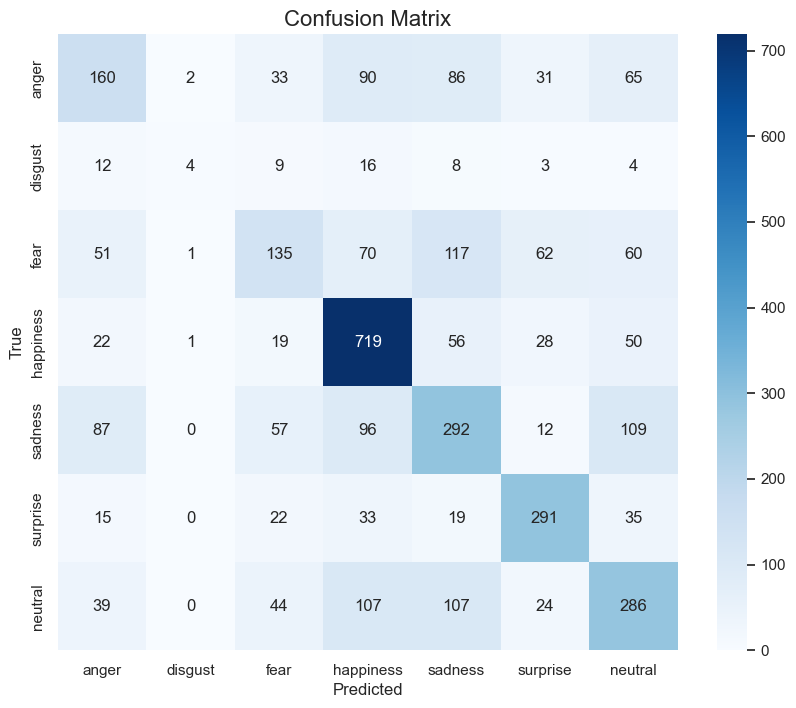



Misclassified Images: 



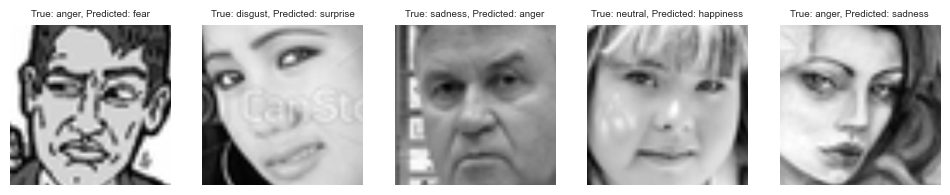

In [86]:
utils.test(convnext_tiny_pretrained, public_test_dataloader, emotions_dict, device, plot_misclassified=True, num_misclassified=5)

Testing:   0%|          | 0/225 [00:00<?, ?it/s]


Classification Report:

              precision    recall  f1-score   support

       anger     0.4380    0.3666    0.3991       491
     disgust     0.2500    0.0364    0.0635        55
        fear     0.3807    0.2386    0.2934       528
   happiness     0.6269    0.8259    0.7128       879
     sadness     0.3994    0.4478    0.4222       594
    surprise     0.6875    0.6875    0.6875       416
     neutral     0.4875    0.4665    0.4767       626

    accuracy                         0.5233      3589
   macro avg     0.4671    0.4385    0.4365      3589
weighted avg     0.5041    0.5233    0.5060      3589





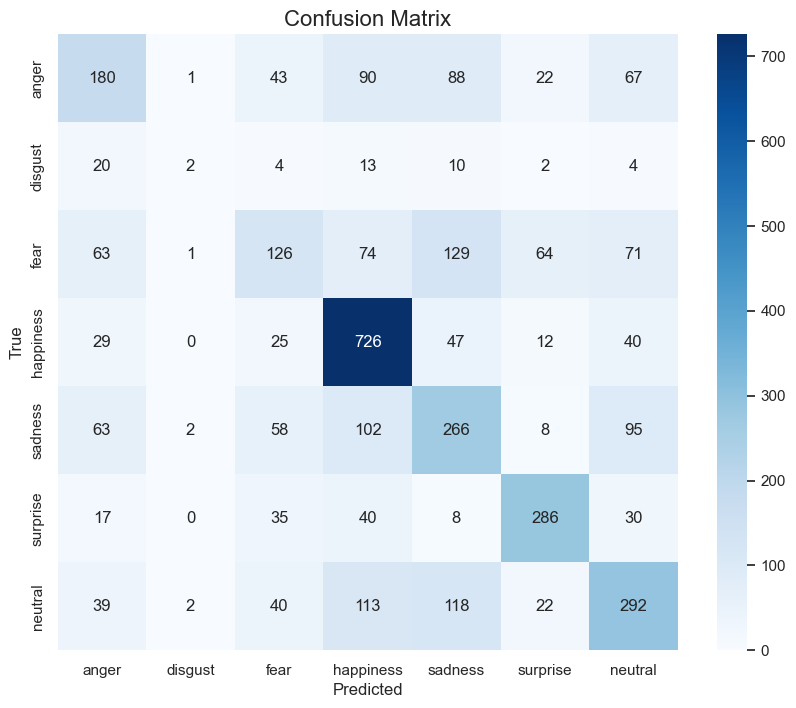



Misclassified Images: 



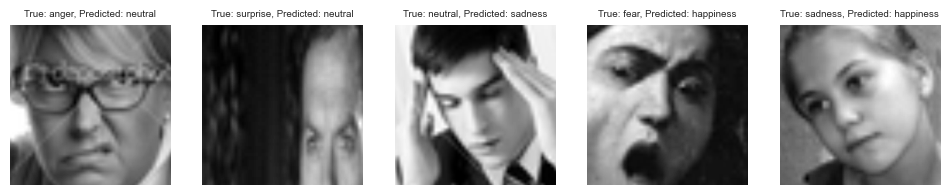

In [87]:
utils.test(convnext_tiny_pretrained, private_test_dataloader, emotions_dict, device, plot_misclassified=True, num_misclassified=5)

# finetune the frozen model with lower learning rate

In [88]:
for param in convnext_tiny_pretrained.parameters():
    param.requires_grad = True

In [89]:
# set up some hyperparams and saving paths
learning_rate = 0.0001
save_path = 'models/CovNext_frozen_finetuned.pth'
epochs = 250
writer = SummaryWriter(log_dir="runs/experiment_CovNext_frozen_finetuned", comment='CovNext_frozen_finetuned')

# Initialize model, loss function, optimizer
convnext_tiny_pretrained.to(device)

# Add the model structure to tensorboard
example_input = torch.randn(1, 3, 224, 224).to(device)
writer.add_graph(convnext_tiny_pretrained, example_input)
writer.close()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(convnext_tiny_pretrained.parameters(), lr=learning_rate)
scaler = GradScaler()

# early stopping
patience = 15

# Start the training loop
#utils.train(train_dataloader, valid_dataloader, convnext_tiny_pretrained, criterion, optimizer, epochs, save_path, writer, device, scaler, patience)

In [90]:
convnext_tiny_pretrained.load_state_dict(torch.load('models/CovNext_frozen_finetuned.pth'))

<All keys matched successfully>

Testing:   0%|          | 0/225 [00:00<?, ?it/s]


Classification Report:

              precision    recall  f1-score   support

       anger     0.6296    0.5460    0.5849       467
     disgust     0.8571    0.2143    0.3429        56
        fear     0.5306    0.4194    0.4685       496
   happiness     0.8368    0.8883    0.8618       895
     sadness     0.5286    0.5528    0.5404       653
    surprise     0.7976    0.7880    0.7927       415
     neutral     0.5605    0.6787    0.6140       607

    accuracy                         0.6604      3589
   macro avg     0.6773    0.5839    0.6007      3589
weighted avg     0.6605    0.6604    0.6549      3589





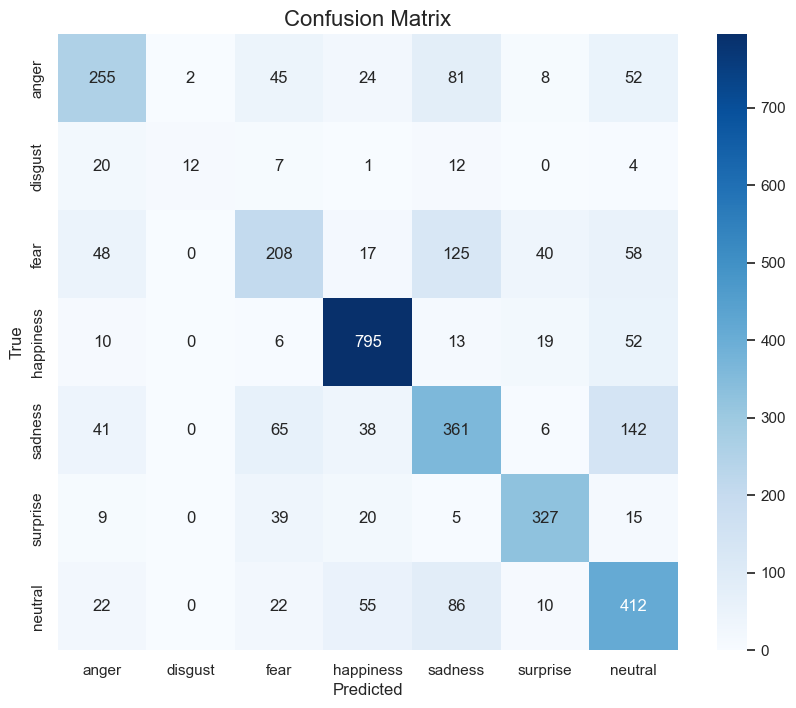



Misclassified Images: 



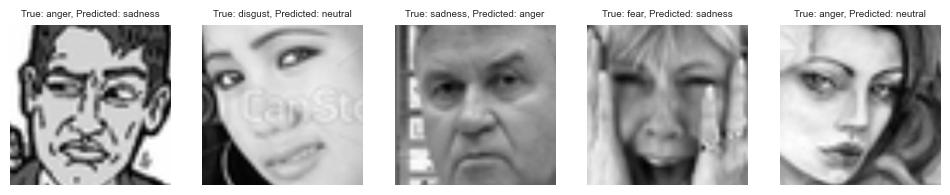

In [91]:
utils.test(convnext_tiny_pretrained, public_test_dataloader, emotions_dict, device, plot_misclassified=True, num_misclassified=5)

Testing:   0%|          | 0/225 [00:00<?, ?it/s]


Classification Report:

              precision    recall  f1-score   support

       anger     0.5986    0.5193    0.5562       491
     disgust     1.0000    0.2000    0.3333        55
        fear     0.5358    0.4110    0.4652       528
   happiness     0.8420    0.9033    0.8716       879
     sadness     0.5099    0.5623    0.5348       594
    surprise     0.7635    0.7452    0.7543       416
     neutral     0.6083    0.7220    0.6603       626

    accuracy                         0.6612      3589
   macro avg     0.6940    0.5805    0.5965      3589
weighted avg     0.6613    0.6612    0.6542      3589





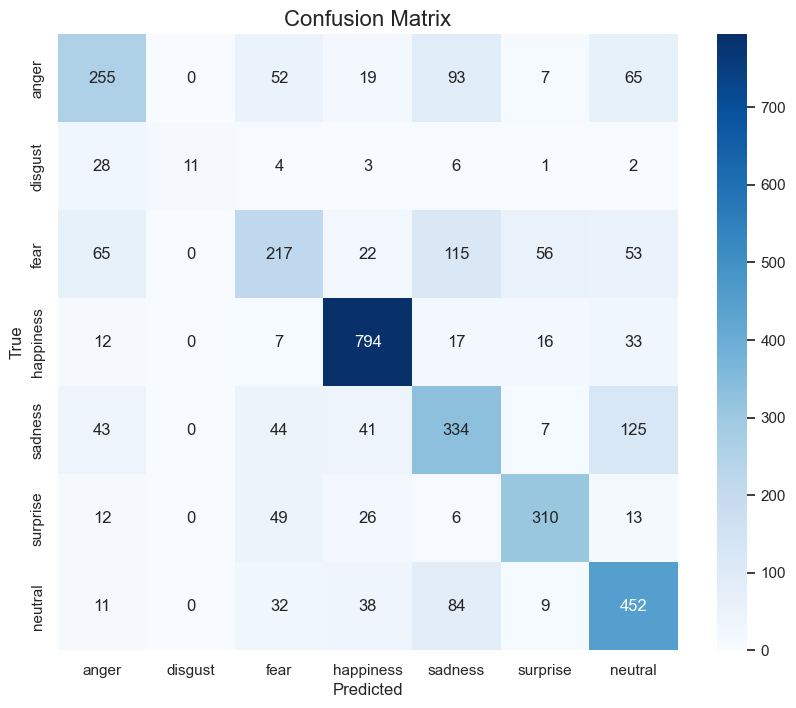



Misclassified Images: 



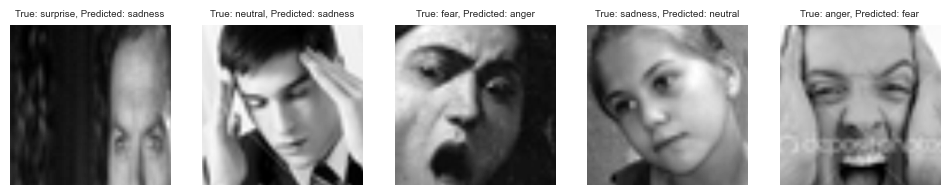

In [92]:
utils.test(convnext_tiny_pretrained, private_test_dataloader, emotions_dict, device, plot_misclassified=True, num_misclassified=5)

# Augmentation

In [93]:
# Define the transformations for ConvNeXt model
resize_size = [230]
crop_size = [224]
normalize_mean = [0.485, 0.456, 0.406]
normalize_std = [0.229, 0.224, 0.225]


train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.RandomResizedCrop(size=(48, 48), scale=(0.8, 1.2), ratio=(0.9, 1.1)),
    transforms.RandomAffine(degrees=10, scale=(0.9, 1.1), shear=5),
    transforms.Resize(resize_size, interpolation=Image.BILINEAR),
    transforms.CenterCrop(crop_size),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=normalize_mean, std=normalize_std)
])



train_dataset = utils.CustomDataset(train_data, train_labels, transform=train_transform)

# split further into train and validation set
validation_set_fraction = 0.15
train_set_length = math.floor(len(train_dataset) * (1-validation_set_fraction))
validation_set_length = math.ceil(len(train_dataset) * (validation_set_fraction))

# train validation split
train_set, val_set = torch.utils.data.random_split(train_dataset, [train_set_length, validation_set_length])

In [94]:
# get the fraction of the trainset used in every epoch
train_set_sample_fraction = 0.025

# Calculate the size of the random train subset based on the fraction
train_subset_size = int(len(train_set) * train_set_sample_fraction)
# number of samples
n_samples = int(len(train_set)*train_set_sample_fraction)

# Use a RandomSampler
random_sampler = RandomSampler(data_source=train_set, num_samples=n_samples, replacement=True)

# DataLoader setup
batch_size = 16

train_dataloader = DataLoader(train_set, batch_size, sampler=random_sampler)

In [95]:
# load tensorboard
%load_ext tensorboard
%tensorboard --logdir=runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [96]:
convnext_tiny_frozen_augmented, parameters_to_optimize = create_custom_convext_net(freeze_pretrained=True)

In [97]:
# set up some hyperparams and saving paths
learning_rate = 0.0001
save_path = 'models/CovNext_frozen_augmented.pth'
epochs = 250
writer = SummaryWriter(log_dir="runs/experiment_CovNext_frozen_augmented.pth", comment='CovNext_frozen_augmented.pth')

# Initialize model, loss function, optimizer
convnext_tiny_frozen_augmented.to(device)

# Add the model structure to tensorboard
example_input = torch.randn(1, 3, 224, 224).to(device)

writer.add_graph(convnext_tiny_frozen_augmented, example_input)
writer.close()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(parameters_to_optimize, lr=learning_rate)
scaler = GradScaler()

# early stopping
patience = 15

# Start the training loop
#utils.train(train_dataloader, valid_dataloader, convnext_tiny_frozen_augmented, criterion, optimizer, epochs, save_path, writer, device, scaler, patience)

# Train on full model with more data

In [98]:
# load tensorboard
%load_ext tensorboard
%tensorboard --logdir=runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 107563), started 0:00:09 ago. (Use '!kill 107563' to kill it.)

In [99]:
convnext_tiny_frozen_augmented.load_state_dict(torch.load('models/CovNext_frozen_augmented.pth'))

<All keys matched successfully>

Testing:   0%|          | 0/225 [00:00<?, ?it/s]


Classification Report:

              precision    recall  f1-score   support

       anger     0.3615    0.3298    0.3449       467
     disgust     0.5000    0.0179    0.0345        56
        fear     0.3306    0.1613    0.2168       496
   happiness     0.5750    0.8134    0.6738       895
     sadness     0.4327    0.3247    0.3710       653
    surprise     0.6034    0.6819    0.6403       415
     neutral     0.4222    0.4827    0.4504       607

    accuracy                         0.4879      3589
   macro avg     0.4608    0.4017    0.3902      3589
weighted avg     0.4638    0.4879    0.4611      3589





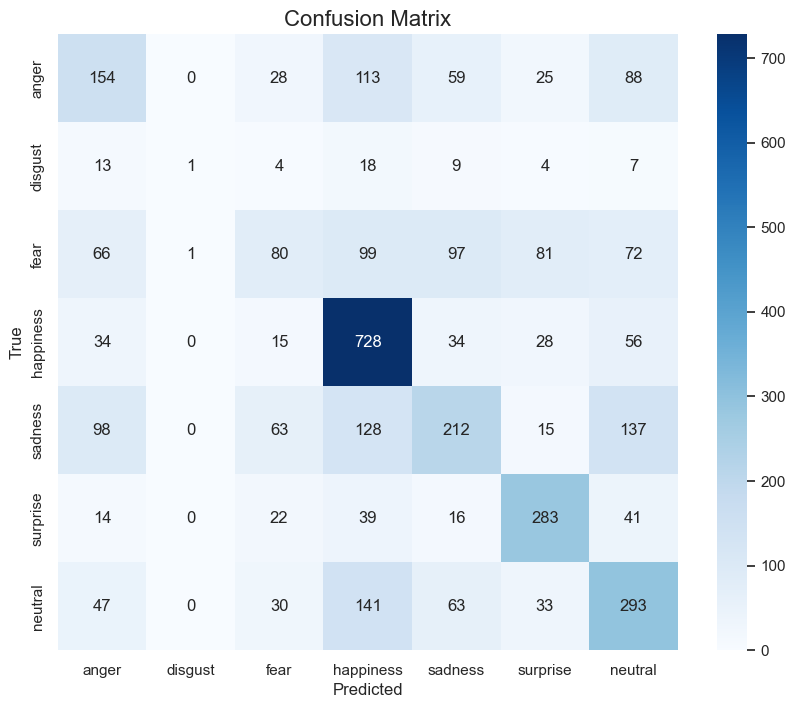



Misclassified Images: 



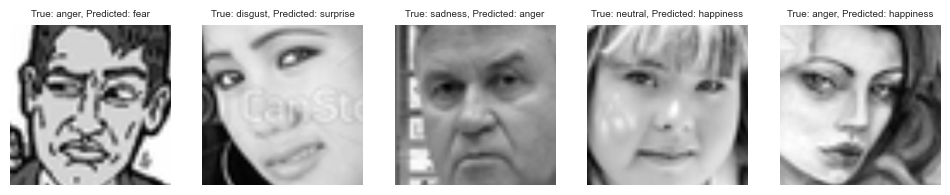

In [100]:
utils.test(convnext_tiny_frozen_augmented, public_test_dataloader, emotions_dict, device, plot_misclassified=True, num_misclassified=5)

In [101]:
for param in convnext_tiny_frozen_augmented.parameters():
    param.requires_grad = True

In [102]:
# get the fraction of the trainset used in every epoch
train_set_sample_fraction = 0.5

# Calculate the size of the random train subset based on the fraction
train_subset_size = int(len(train_set) * train_set_sample_fraction)
# number of samples
n_samples = int(len(train_set)*train_set_sample_fraction)

# Use a RandomSampler
random_sampler = RandomSampler(data_source=train_set, num_samples=n_samples, replacement=True)

# DataLoader setup
batch_size = 32

train_dataloader = DataLoader(train_set, batch_size, sampler=random_sampler)

In [103]:
# set up some hyperparams and saving paths
learning_rate = 0.00001
save_path = 'models/CovNext_finetuned_augmented.pth'
epochs = 250
writer = SummaryWriter(log_dir="runs/experiment_CovNext_finetuned_augmented.pth", comment='CovNext_finetuned_augmented.pth')

# Initialize model, loss function, optimizer
convnext_tiny_frozen_augmented.to(device)

# Add the model structure to tensorboard
example_input = torch.randn(1, 3, 224, 224).to(device)

writer.add_graph(convnext_tiny_frozen_augmented, example_input)
writer.close()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(convnext_tiny_frozen_augmented.parameters(), lr=learning_rate)
scaler = GradScaler()

# early stopping
patience = 15

# Start the training loop
#utils.train(train_dataloader, valid_dataloader, convnext_tiny_frozen_augmented, criterion, optimizer, epochs, save_path, writer, device, scaler, patience)

In [104]:
convnext_tiny_frozen_augmented.load_state_dict(torch.load('models/CovNext_finetuned_augmented.pth'))

<All keys matched successfully>

Testing:   0%|          | 0/225 [00:00<?, ?it/s]


Classification Report:

              precision    recall  f1-score   support

       anger     0.5951    0.6231    0.6088       467
     disgust     0.8611    0.5536    0.6739        56
        fear     0.5727    0.5161    0.5429       496
   happiness     0.8786    0.8413    0.8596       895
     sadness     0.5585    0.6064    0.5815       653
    surprise     0.7903    0.8265    0.8080       415
     neutral     0.6143    0.6244    0.6193       607

    accuracy                         0.6824      3589
   macro avg     0.6958    0.6559    0.6706      3589
weighted avg     0.6860    0.6824    0.6831      3589





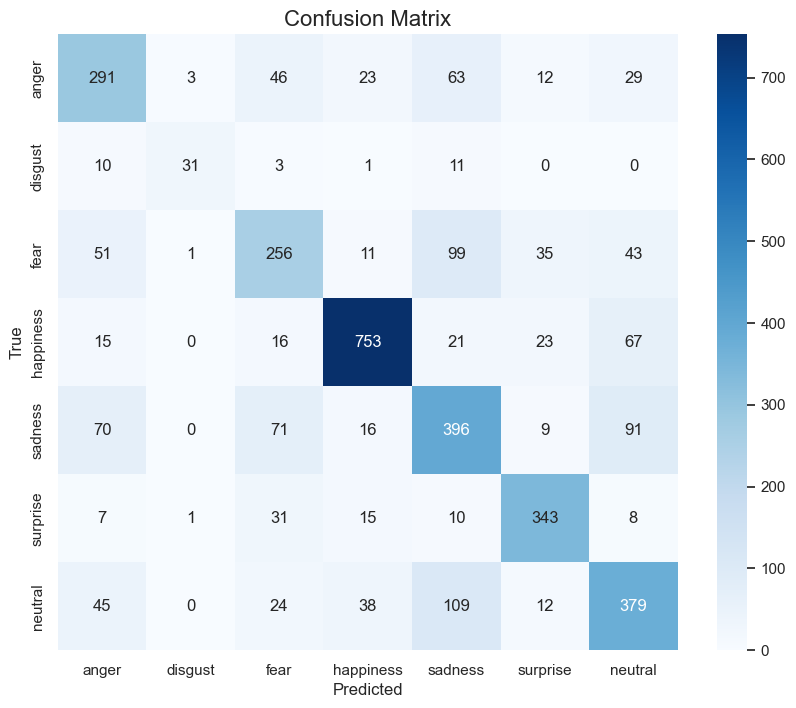



Misclassified Images: 



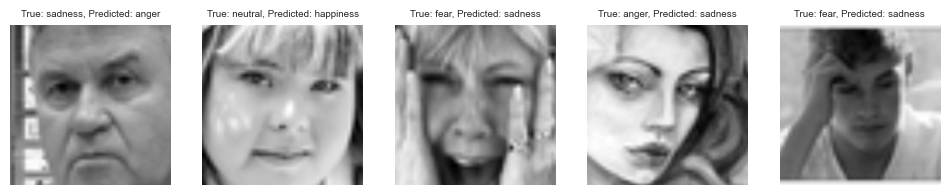

In [106]:
utils.test(convnext_tiny_frozen_augmented, public_test_dataloader, emotions_dict, device, plot_misclassified=True, num_misclassified=5)

In [92]:
#utils.test(convnext_tiny_frozen_augmented, private_test_dataloader, emotions_dict, device, plot_misclassified=True, num_misclassified=20)

# Finetune the previously best model on the augmented data

In [110]:
convnext_tiny_best, parameters_to_optimize = create_custom_convext_net(freeze_pretrained=False)

In [111]:
convnext_tiny_best.load_state_dict(torch.load('models/CovNext_frozen_finetuned.pth'))

<All keys matched successfully>

In [112]:
# set up some hyperparams and saving paths
learning_rate = 0.0001
save_path = 'models/CovNext_best.pth'
epochs = 250
writer = SummaryWriter(log_dir="runs/experiment_CovNext_best", comment='CovNext_best')

# Initialize model, loss function, optimizer
convnext_tiny_best.to(device)

# Add the model structure to tensorboard
example_input = torch.randn(1, 3, 224, 224).to(device)

writer.add_graph(convnext_tiny_best, example_input)
writer.close()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(convnext_tiny_best.parameters(), lr=learning_rate)
scaler = GradScaler()

# early stopping
patience = 15

# Start the training loop
#utils.train(train_dataloader, valid_dataloader, convnext_tiny_best, criterion, optimizer, epochs, save_path, writer, device, scaler, patience)

In [113]:
convnext_tiny_best.load_state_dict(torch.load('models/CovNext_best.pth'))

<All keys matched successfully>

In [114]:
#utils.test(convnext_tiny_best, public_test_dataloader, emotions_dict, device, plot_misclassified=True, num_misclassified=20)

In [115]:
#utils.test(convnext_tiny_best, private_test_dataloader, emotions_dict, device, plot_misclassified=True, num_misclassified=20)

# finetune further on more data and less learning rate

In [116]:
convnext_tiny_best.load_state_dict(torch.load('models/CovNext_best_finetuned.pth'))

<All keys matched successfully>

In [117]:
# get the fraction of the trainset used in every epoch
train_set_sample_fraction = 0.5

# Calculate the size of the random train subset based on the fraction
train_subset_size = int(len(train_set) * train_set_sample_fraction)
# number of samples
n_samples = int(len(train_set)*train_set_sample_fraction)

# Use a RandomSampler
random_sampler = RandomSampler(data_source=train_set, num_samples=n_samples, replacement=True)

# DataLoader setup
batch_size = 32

train_dataloader = DataLoader(train_set, batch_size, sampler=random_sampler)

In [118]:
# set up some hyperparams and saving paths
learning_rate = 0.000005
save_path = 'models/CovNext_best_finetuned2.pth'
epochs = 250
writer = SummaryWriter(log_dir="runs/experiment_CovNext_best_finetuned2.pth", comment='CovNext_best_finetuned2.pth')

# Initialize model, loss function, optimizer
convnext_tiny_best.to(device)

# Add the model structure to tensorboard
example_input = torch.randn(1, 3, 224, 224).to(device)

writer.add_graph(convnext_tiny_best, example_input)
writer.close()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(convnext_tiny_best.parameters(), lr=learning_rate)
scaler = GradScaler()

# early stopping
patience = 15

In [119]:
#utils.train(train_dataloader, valid_dataloader, convnext_tiny_best, criterion, optimizer, epochs, save_path, writer, device, scaler, patience)

In [120]:
convnext_tiny_best.load_state_dict(torch.load('models/CovNext_best_finetuned.pth'))

<All keys matched successfully>

Testing:   0%|          | 0/225 [00:00<?, ?it/s]


Classification Report:

              precision    recall  f1-score   support

       anger     0.6188    0.6188    0.6188       467
     disgust     0.8049    0.5893    0.6804        56
        fear     0.5957    0.5081    0.5484       496
   happiness     0.8709    0.8816    0.8762       895
     sadness     0.5602    0.6126    0.5852       653
    surprise     0.8163    0.8458    0.8308       415
     neutral     0.6266    0.6277    0.6272       607

    accuracy                         0.6952      3589
   macro avg     0.6991    0.6691    0.6810      3589
weighted avg     0.6949    0.6952    0.6940      3589





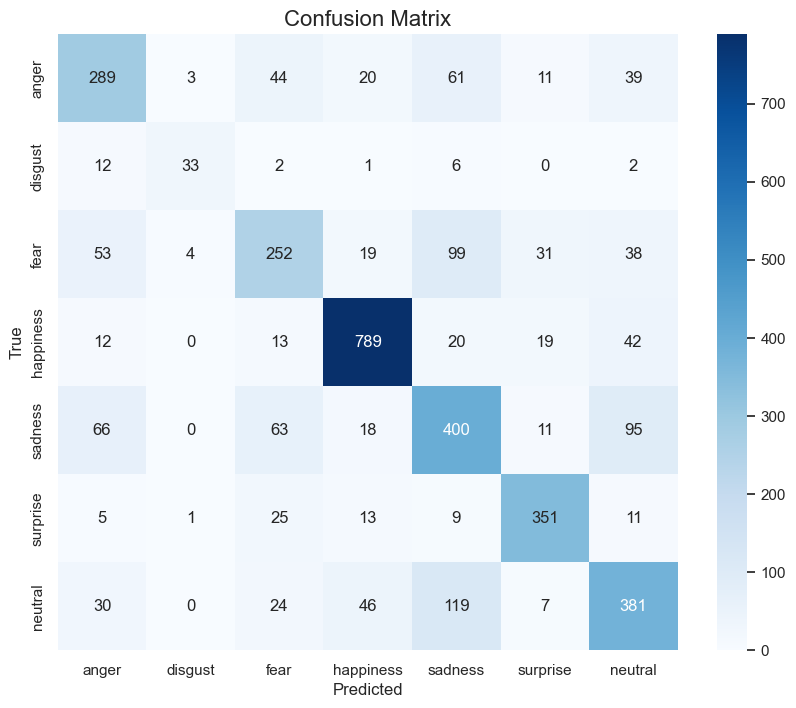



Misclassified Images: 



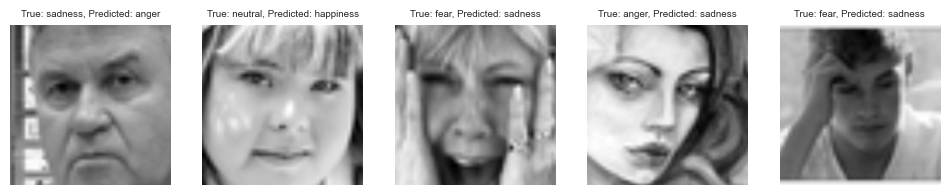

In [121]:
utils.test(convnext_tiny_best, public_test_dataloader, emotions_dict, device, plot_misclassified=True, num_misclassified=5)

Testing:   0%|          | 0/225 [00:00<?, ?it/s]


Classification Report:

              precision    recall  f1-score   support

       anger     0.6468    0.6191    0.6327       491
     disgust     0.8367    0.7455    0.7885        55
        fear     0.6061    0.5246    0.5624       528
   happiness     0.9048    0.8976    0.9012       879
     sadness     0.5413    0.5960    0.5673       594
    surprise     0.8066    0.8221    0.8143       416
     neutral     0.6652    0.7045    0.6843       626

    accuracy                         0.7099      3589
   macro avg     0.7154    0.7013    0.7072      3589
weighted avg     0.7112    0.7099    0.7097      3589





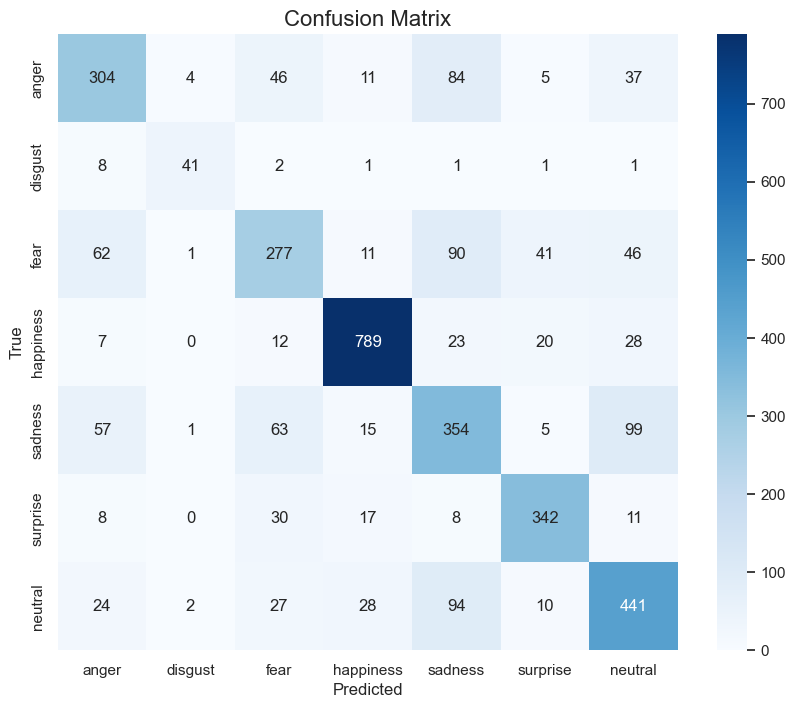



Misclassified Images: 



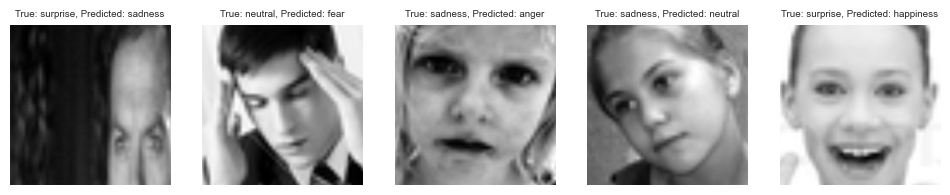

In [123]:
utils.test(convnext_tiny_best, private_test_dataloader, emotions_dict, device, plot_misclassified=True, num_misclassified=5)